One idea for examples:
1. Show behavior of grid search vs. random optimization vs. bayesian optimization for different utility functions (patient 1)
2. Show qualitative differences between bayesian optimal solutions for different utility functions (all patients)

In [2]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)

sys.path.append('../../src')
import analyze
import raybay

In [3]:
# Load treatment plan results
approved = np.load('approved/res.pkl', allow_pickle=True)
default = np.load('default/res.pkl', allow_pickle=True)

In [4]:
# Clinical goals
default.goal_df

,Roi,Type,GoalCriteria,AcceptanceLevel,ParameterValue
0,Chestwall_L,MaxDvh,AtMost,3000,2.04
1,D2cm,MaxDose,AtMost,2400,NaN
2,Esophagus,MaxDvh,AtMost,1880,16.91
3,Lungs,MaxDvh,AtMost,1160,29.19
4,Lungs,MaxDvh,AtMost,1240,19.46
5,PTV,MinDvh,AtLeast,4800,95.00
6,PTV,MaxDose,AtMost,8000,NaN
7,Rib,MaxDvh,AtMost,3200,0.27
8,Rib,MaxDose,AtMost,4000,NaN
9,SpinalCanal,MaxDvh,AtMost,1360,2.30


In [5]:
# Constituent functions (D2cm = [0,2400] and Rib = [0,4000])
default.func_df

,Roi,FunctionType,DoseLevel,PercentVolume,EudParameterA,Weight
0,Chestwall_L,MaxDvh,3000,2.04,NaN,1
1,D2cm,MaxDose,2400,0.00,NaN,1
2,Esophagus,MaxDvh,1880,16.91,NaN,1
3,Lungs,MaxDvh,1160,29.19,NaN,1
4,Lungs,MaxDvh,1240,19.46,NaN,1
5,PTV,MinDvh,4800,95.00,NaN,1
6,PTV,MaxDose,8000,0.00,NaN,1
7,Rib,MaxDvh,3200,0.27,NaN,1
8,Rib,MaxDose,4000,0.00,NaN,1
9,SpinalCanal,MaxDvh,1360,2.30,NaN,1


# 2D Grid Search Results

In [6]:
# Load 2D grid search results (computed in batches due to connection timing out)
goal_dict_1 = np.load('grid2/goal_dict_1.pkl', allow_pickle=True) # (0,0) - (100,2700)
goal_dict_2 = np.load('grid2/goal_dict_2.pkl', allow_pickle=True) # (200,0) - (700,100)
goal_dict_3 = np.load('grid2/goal_dict_3.pkl', allow_pickle=True) # (100,2800) - (100,4000)
goal_dict_4 = np.load('grid2/goal_dict_4.pkl', allow_pickle=True) # (700,0) - (1200,2000)
goal_dict_5 = np.load('grid2/goal_dict_5.pkl', allow_pickle=True) # (1200,2100) - (1200,4000)
goal_dict_6 = np.load('grid2/goal_dict_6.pkl', allow_pickle=True) # (1300,0) - (1500,2200)
goal_dict_7 = np.load('grid2/goal_dict_7.pkl', allow_pickle=True) # (1500,2300) - (1500,4000)
goal_dict_8 = np.load('grid2/goal_dict_8.pkl', allow_pickle=True) # (1600,0) - (2400,4000)

In [7]:
# Compile Clinical goal results
d2cm_grid = np.arange(0, 2500, 100)
rib_grid = np.arange(0, 4100, 100)
goal_dict = {ii: goal_dict_1[ii].copy() for ii in goal_dict_1}
for ii in goal_dict:
    goal_dict[ii] += goal_dict_3[ii]
    goal_dict[ii] += goal_dict_2[ii][:-2]
    goal_dict[ii] += goal_dict_4[ii]
    goal_dict[ii] += goal_dict_5[ii]
    goal_dict[ii] += goal_dict_6[ii]
    goal_dict[ii] += goal_dict_7[ii]
    goal_dict[ii] += goal_dict_8[ii]
x_iters = [[ii, jj] for ii in d2cm_grid for jj in rib_grid]
[X, Y] = np.meshgrid(d2cm_grid, rib_grid)

In [8]:
# Read log files to get flags
flag_list_1 = []
f = open('grid2/log_grid_1.txt', 'r')
for line in f:
    flag = int(line.split()[4][:-1])
    flag_list_1.append(flag)
f.close()

flag_list_2 = []
f = open('grid2/log_grid_2.txt', 'r')
for line in f:
    flag = int(line.split()[4][:-1])
    flag_list_2.append(flag)
f.close()

flag_list_3 = []
f = open('grid2/log_grid_3.txt', 'r')
for line in f:
    flag = int(line.split()[3][:-1])
    flag_list_3.append(flag)
f.close()

flag_list_4 = []
f = open('grid2/log_grid_4.txt', 'r')
for line in f:
    flag = int(line.split()[4][:-1])
    flag_list_4.append(flag)
f.close()

flag_list_5 = []
f = open('grid2/log_grid_5.txt', 'r')
for line in f:
    flag = int(line.split()[3][:-1])
    flag_list_5.append(flag)
f.close()

flag_list_6 = []
f = open('grid2/log_grid_6.txt', 'r')
for line in f:
    flag = int(line.split()[4][:-1])
    flag_list_6.append(flag)
f.close()

flag_list_7 = []
f = open('grid2/log_grid_7.txt', 'r')
for line in f:
    flag = int(line.split()[3][:-1])
    flag_list_7.append(flag)
f.close()

flag_list_8 = []
f = open('grid2/log_grid_8.txt', 'r')
for line in f:
    flag = int(line.split()[4][:-1])
    flag_list_8.append(flag)
f.close()

In [9]:
# Compile flag lists
flag_list = flag_list_1.copy()
flag_list += flag_list_3
flag_list += flag_list_2[:-2]
flag_list += flag_list_4
flag_list += flag_list_5
flag_list += flag_list_6
flag_list += flag_list_7
flag_list += flag_list_8

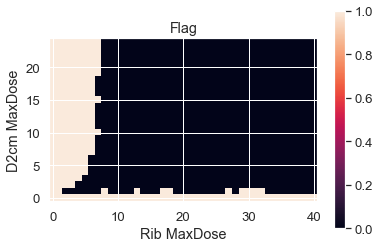

In [10]:
# Flags vs. parameters (0 = good, 1 = RayStation unable to normalize to PTV D95)
Z = np.zeros_like(X)
F = np.ones_like(X)
k = 0
for ii in range(len(d2cm_grid)):
    for jj in range(len(rib_grid)):
        Z[jj, ii] = flag_list[k]
        F[jj, ii] = 0 if flag_list[k] == 1 else 1
        k += 1
plt.imshow(Z.T, origin='lower')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Flag')
plt.colorbar();

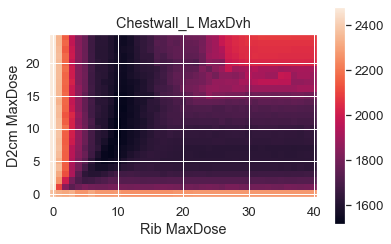

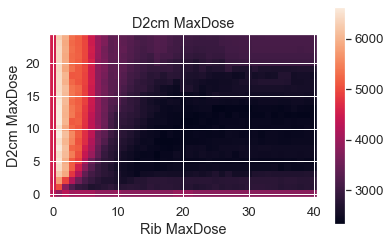

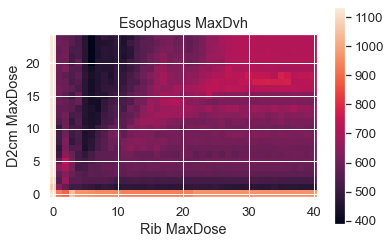

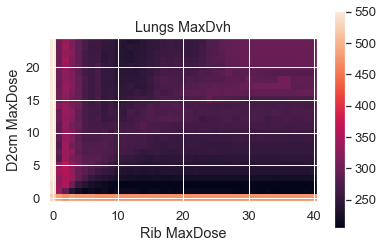

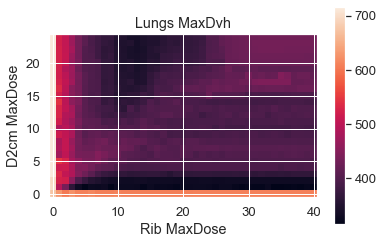

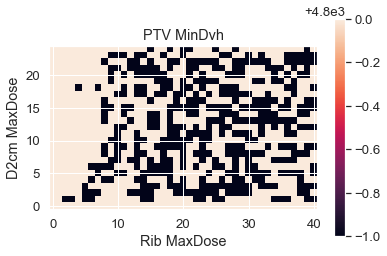

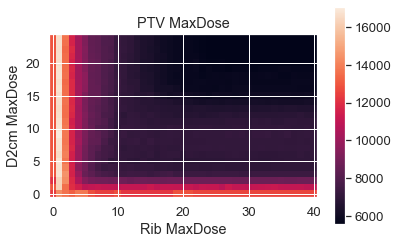

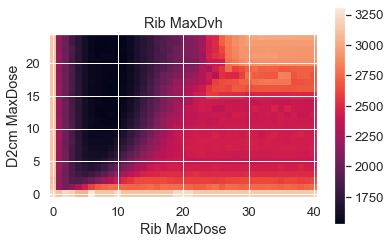

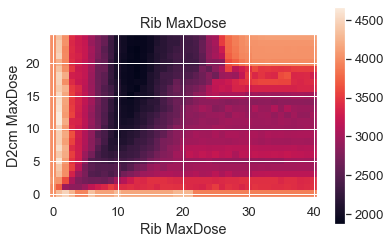

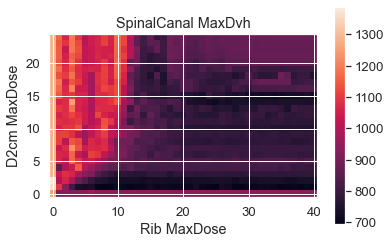

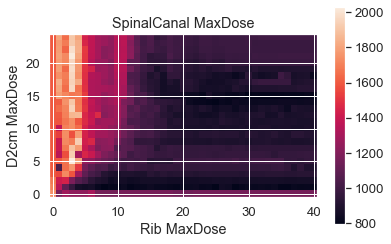

In [7]:
# Goal values vs. parameters (absolute values)
for goal in goal_dict:
    Z = np.zeros_like(X)
    k = 0
    for ii in range(len(d2cm_grid)):
        for jj in range(len(rib_grid)):
            Z[jj, ii] = goal_dict[goal][k]
            k += 1
    plt.figure()
    plt.imshow(Z.T, origin='lower')
    plt.xlabel('Rib MaxDose')
    plt.ylabel('D2cm MaxDose')
    plt.title(f"{default.goal_df.iloc[goal]['Roi']} {default.goal_df.iloc[goal]['Type']}")
    plt.colorbar()

In [11]:
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.diverging_palette(220, 20, n=256).as_hex())

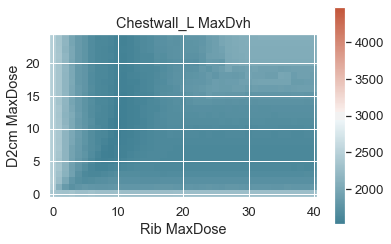

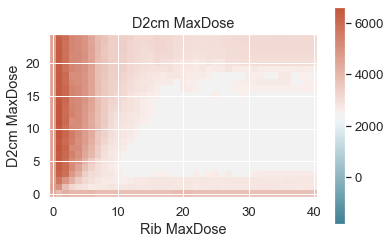

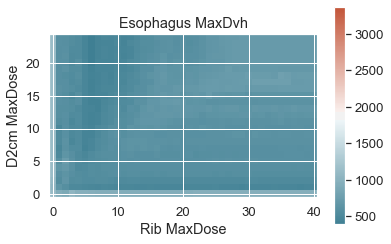

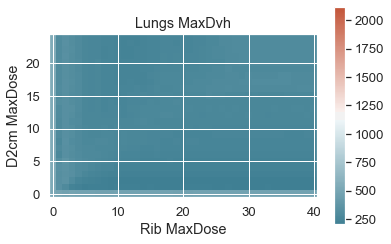

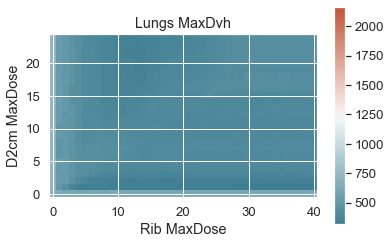

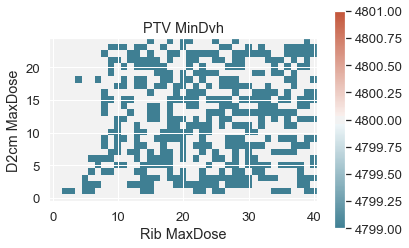

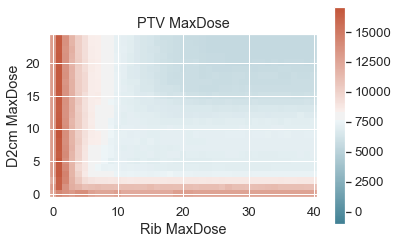

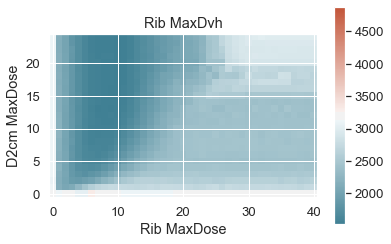

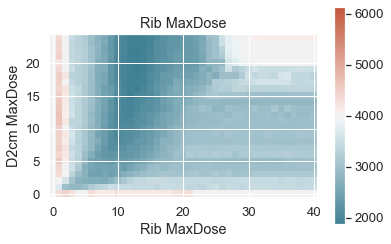

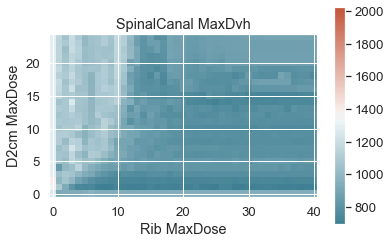

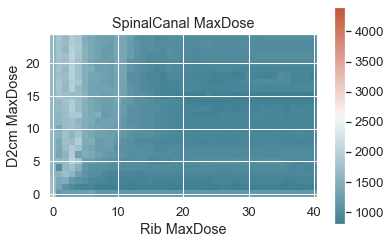

In [19]:
# Goal values vs. parameters (absolute values)
for goal in goal_dict:
    Z = np.zeros_like(X)
    k = 0
    for ii in range(len(d2cm_grid)):
        for jj in range(len(rib_grid)):
            Z[jj, ii] = goal_dict[goal][k]
            k += 1
    plt.figure()
    level = default.goal_df.iloc[goal]['AcceptanceLevel']
    vval = np.max(np.abs(Z - level))
    plt.imshow(Z.T, origin='lower', cmap=my_cmap, vmin=level+vval, vmax=level-vval)
    plt.xlabel('Rib MaxDose')
    plt.ylabel('D2cm MaxDose')
    plt.title(f"{default.goal_df.iloc[goal]['Roi']} {default.goal_df.iloc[goal]['Type']}")
    plt.colorbar()

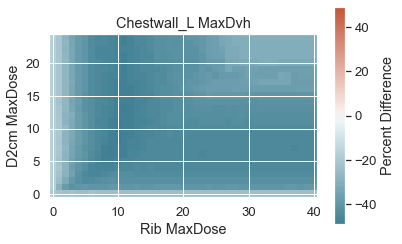

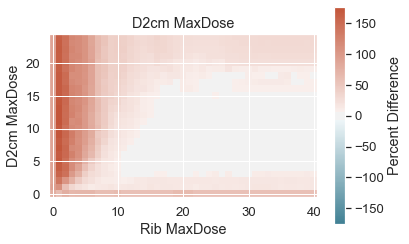

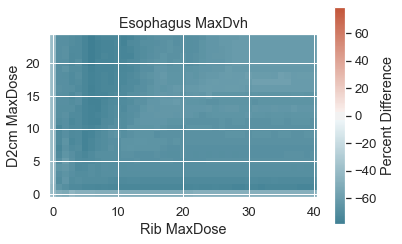

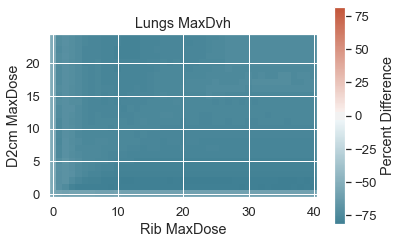

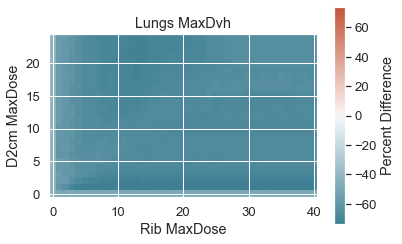

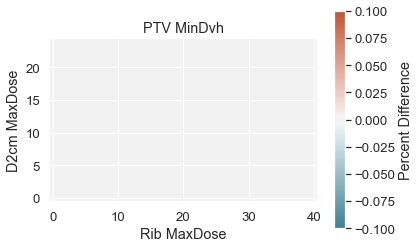

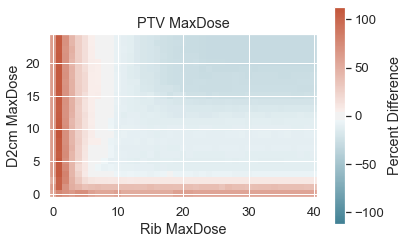

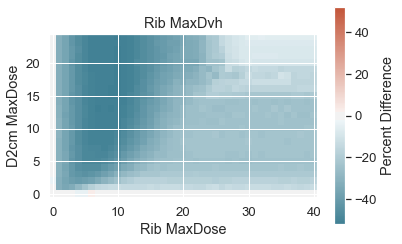

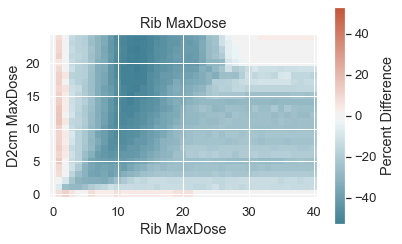

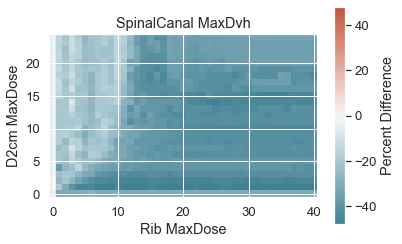

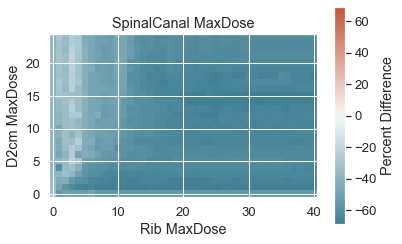

In [23]:
# Goal values vs. parameters (relative values)
for goal in goal_dict:
    Z = np.zeros_like(X)
    k = 0
    for ii in range(len(d2cm_grid)):
        for jj in range(len(rib_grid)):
            level = default.goal_df.iloc[goal]['AcceptanceLevel']
            Z[jj, ii] = 100*(goal_dict[goal][k] - level)/level
            k += 1
    plt.figure()
    vval = np.max(np.abs(Z))
    plt.imshow(Z.T, origin='lower', cmap=my_cmap, vmin=-vval, vmax=vval)
    plt.xlabel('Rib MaxDose')
    plt.ylabel('D2cm MaxDose')
    plt.title(f"{default.goal_df.iloc[goal]['Roi']} {default.goal_df.iloc[goal]['Type']}")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Percent Difference')

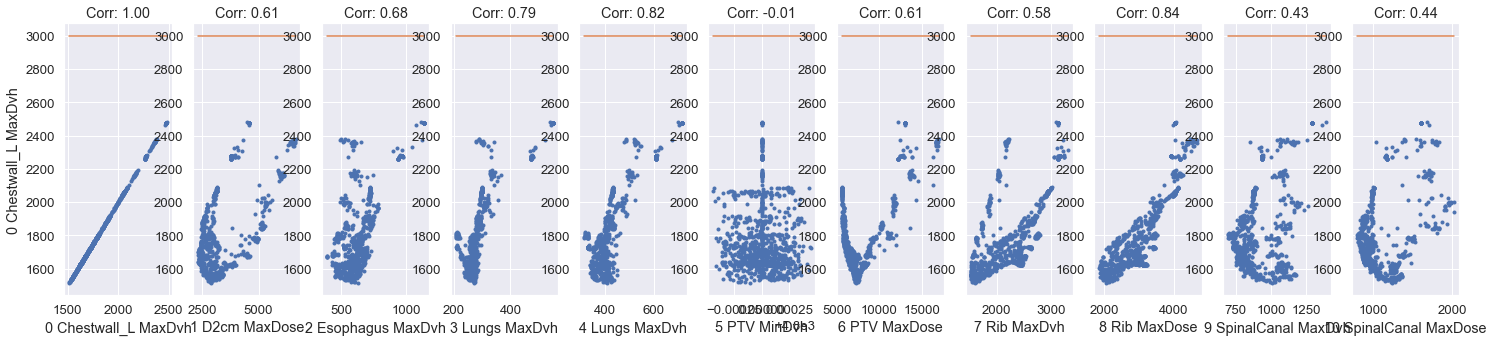

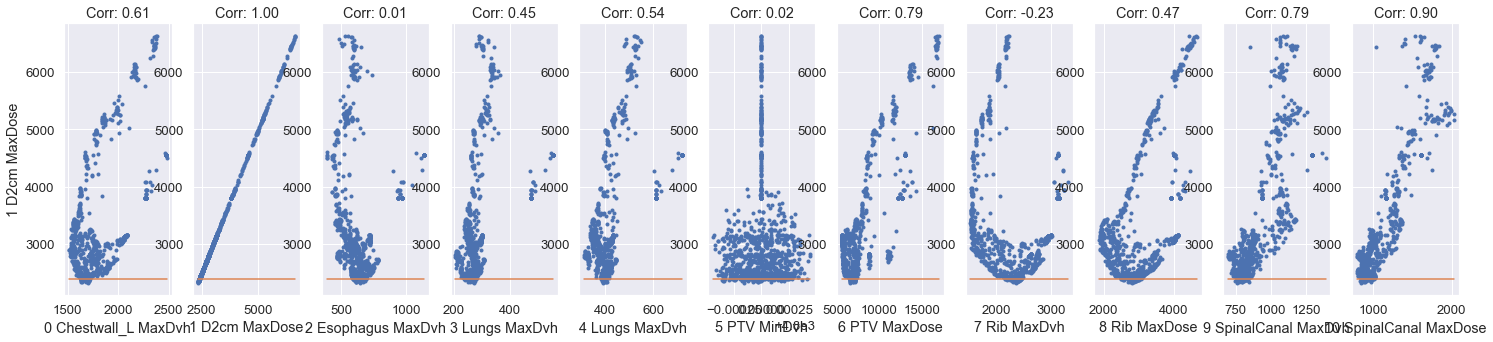

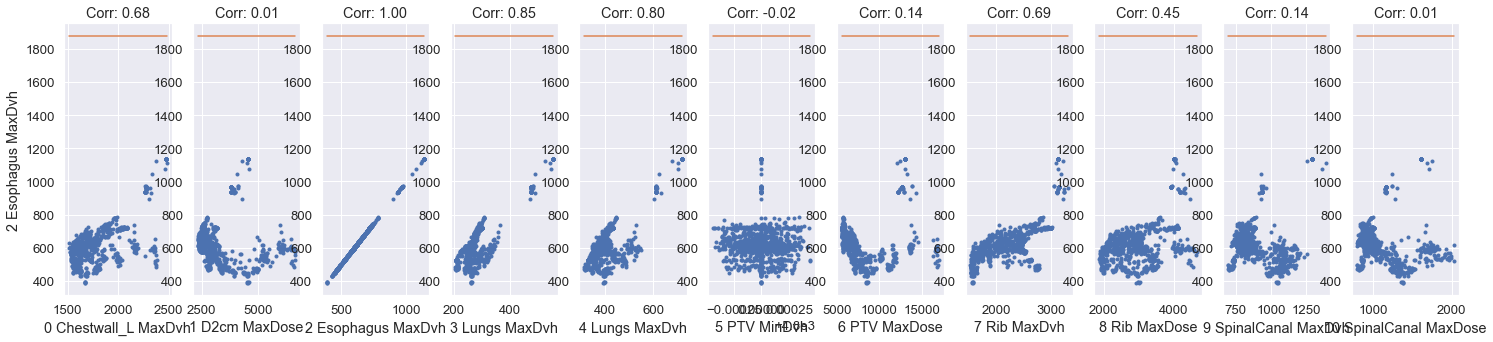

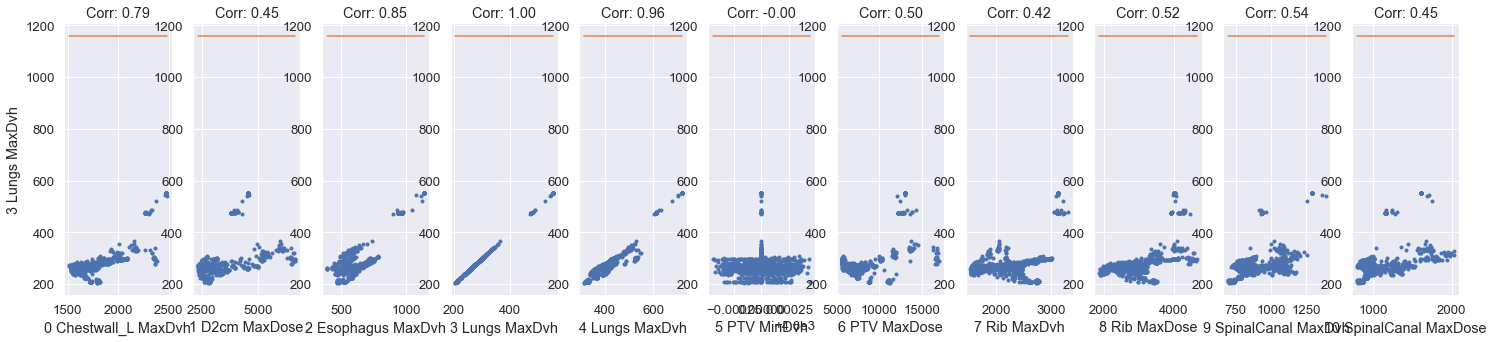

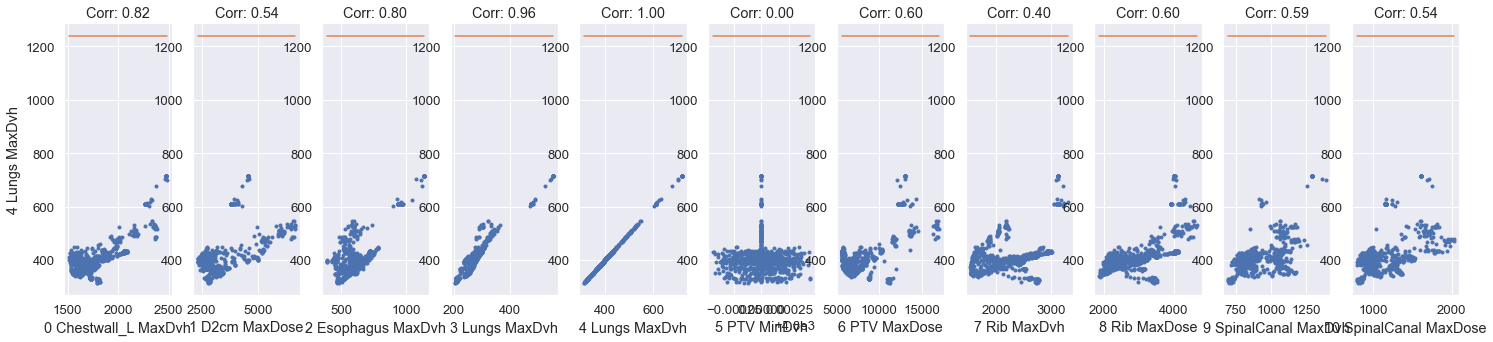

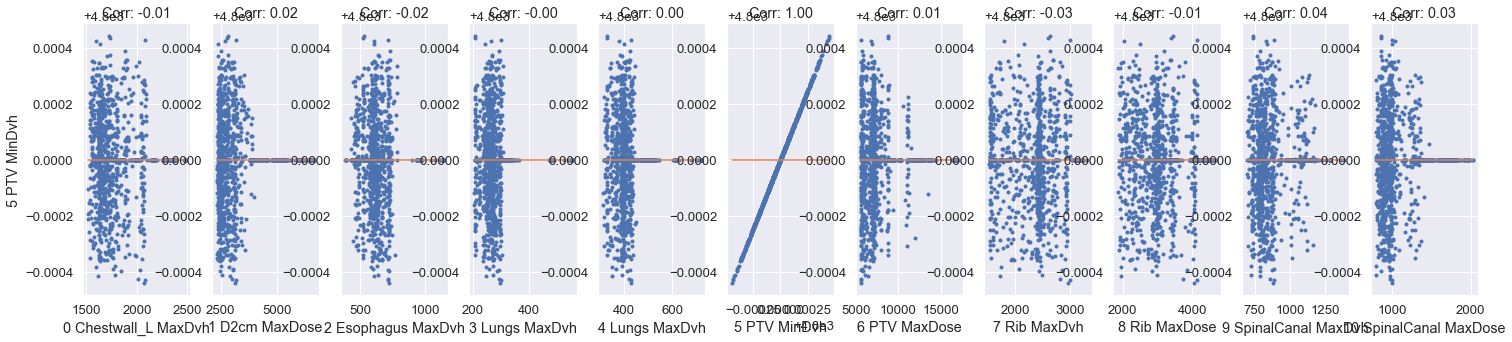

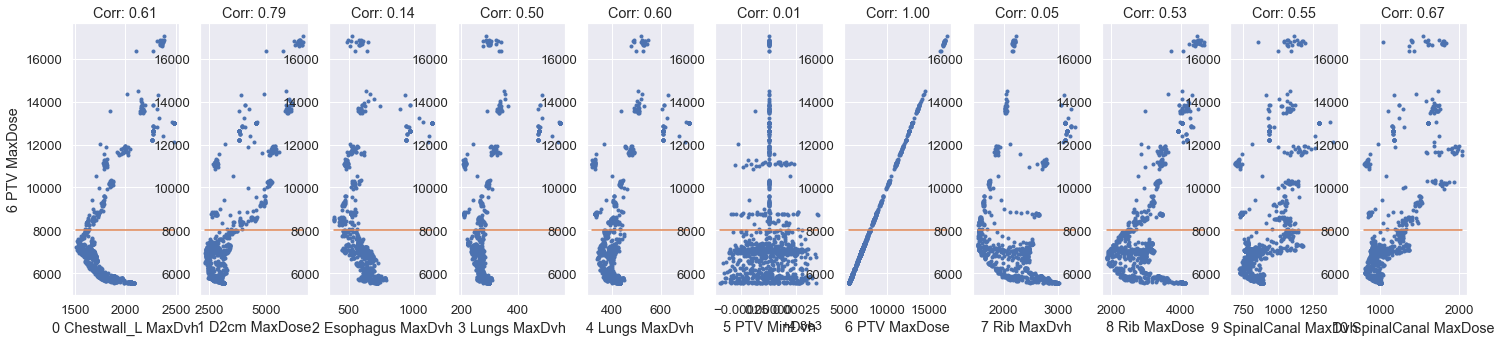

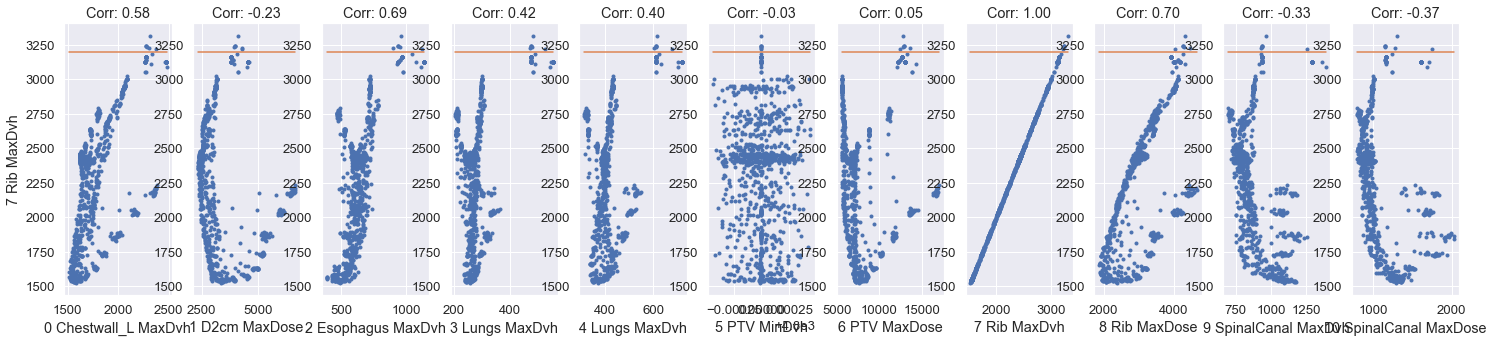

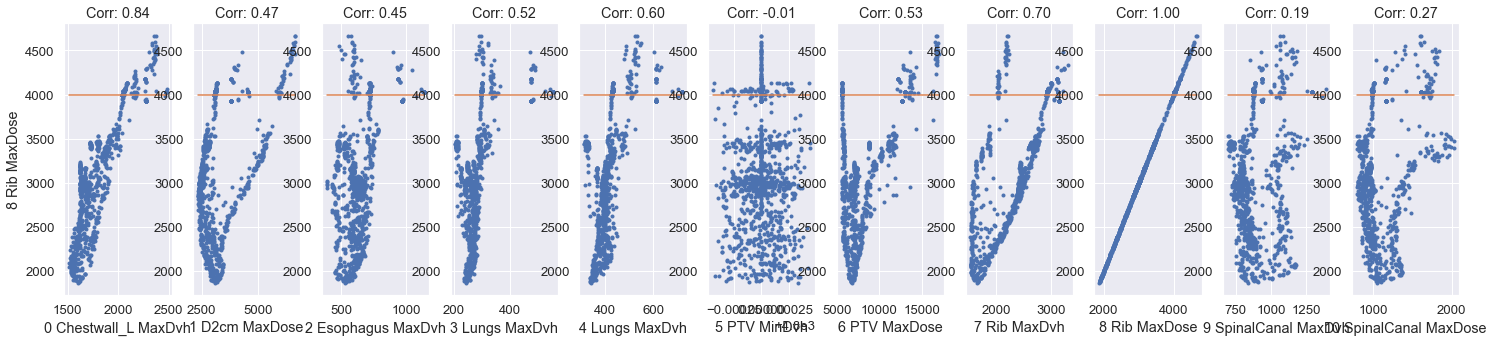

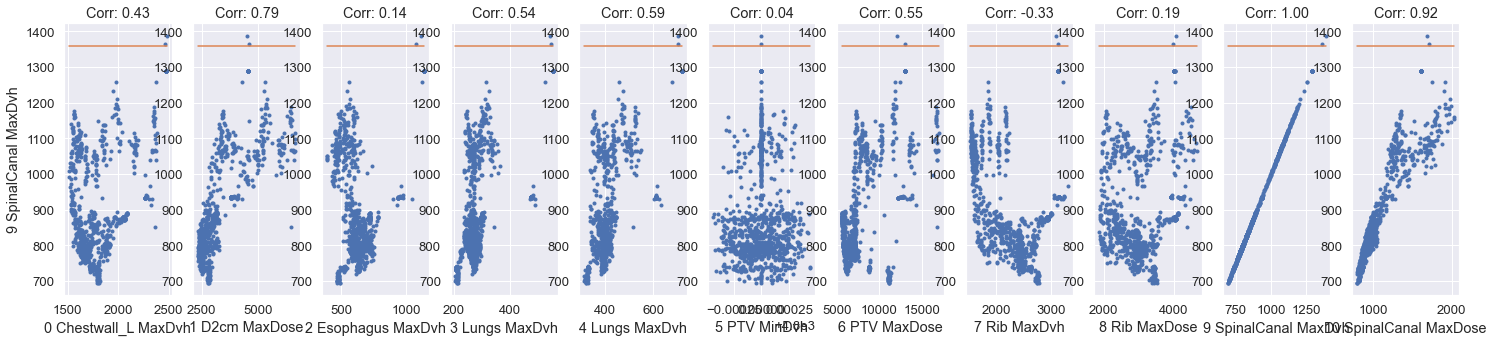

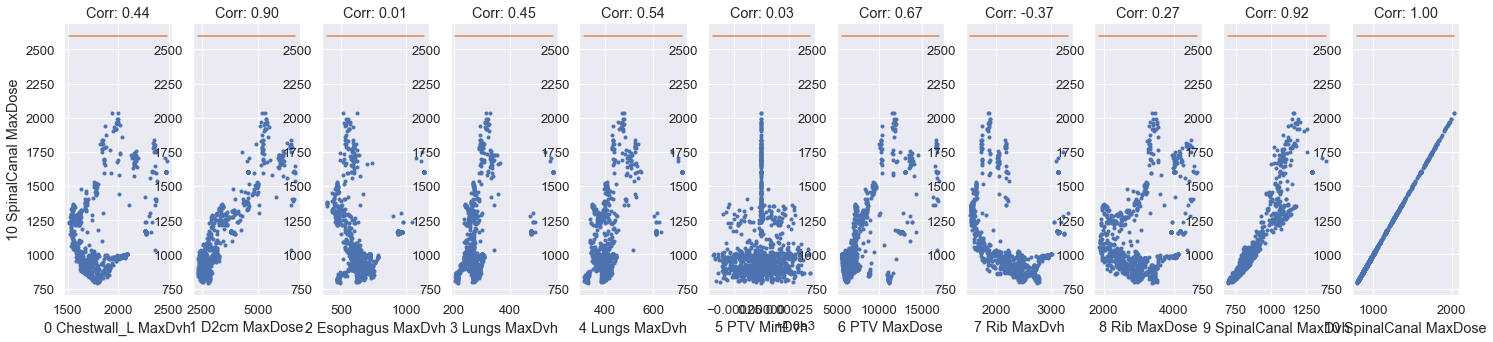

In [216]:
# Goal values vs. goal values
analyze.scatterplot(default.goal_df, goal_dict) # would be nice to color by flag, add vertical goal lines

# what about also just plotting values where all goals are met?

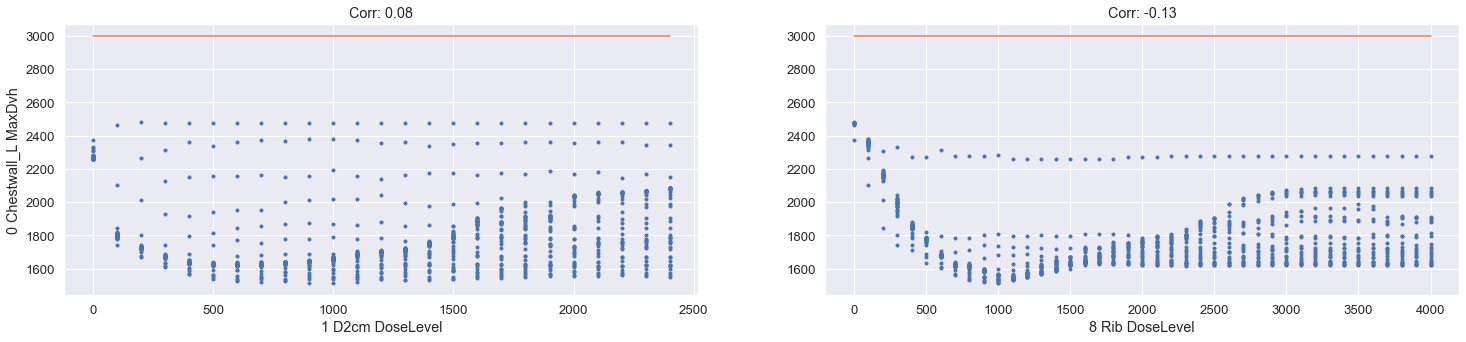

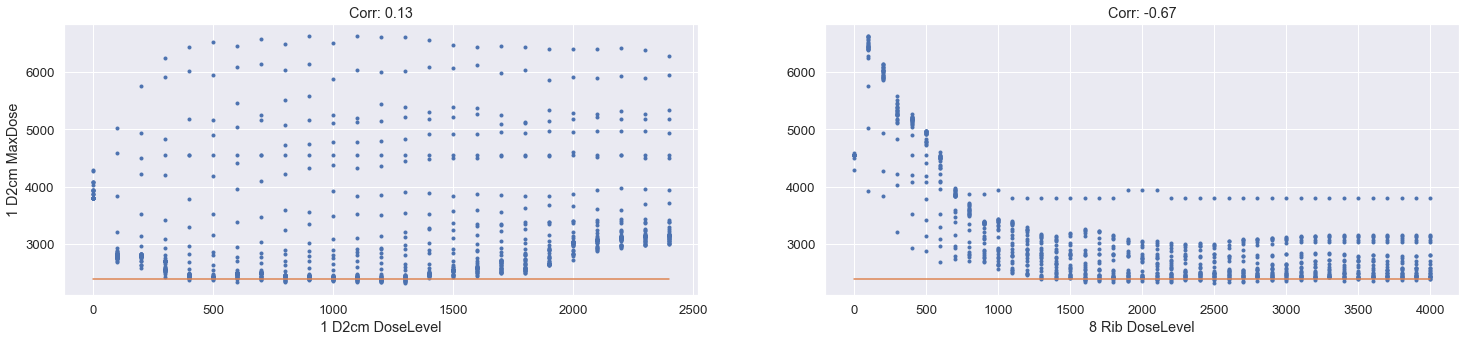

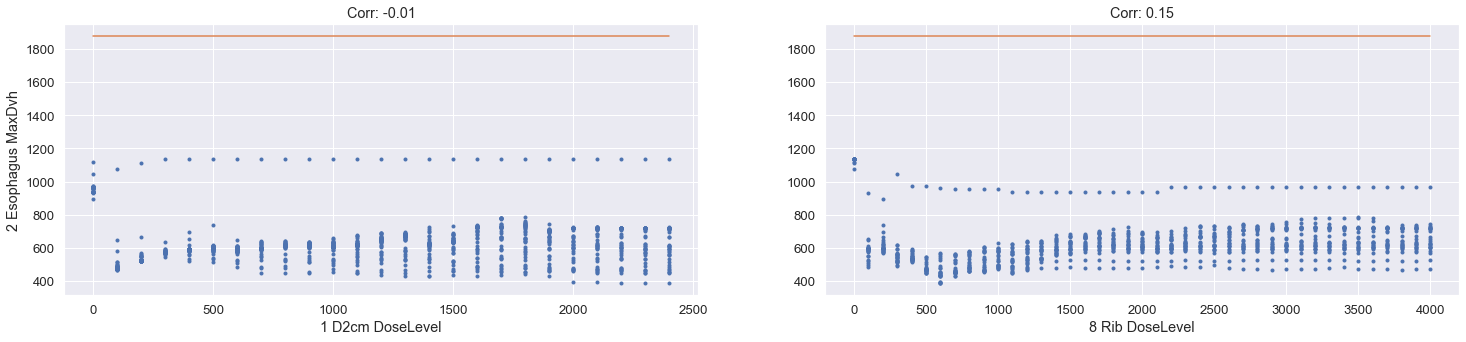

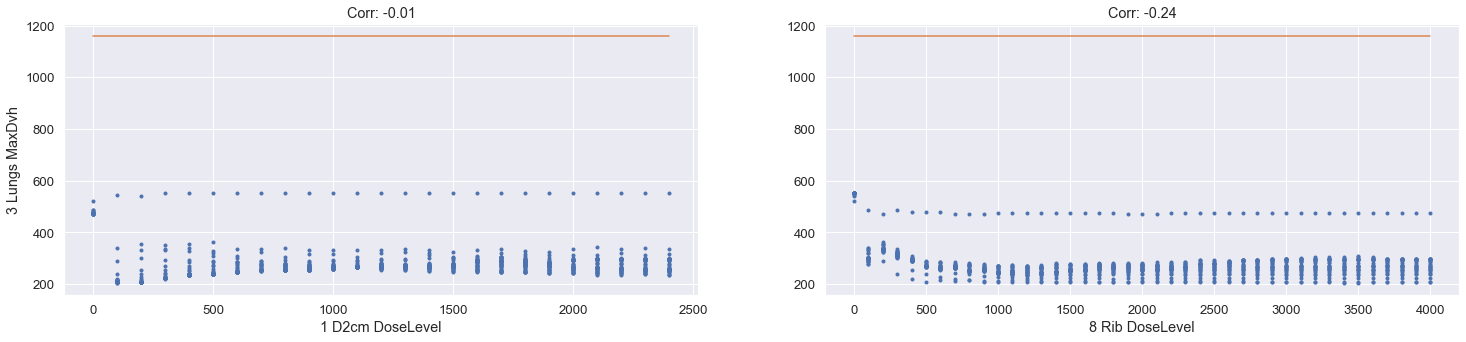

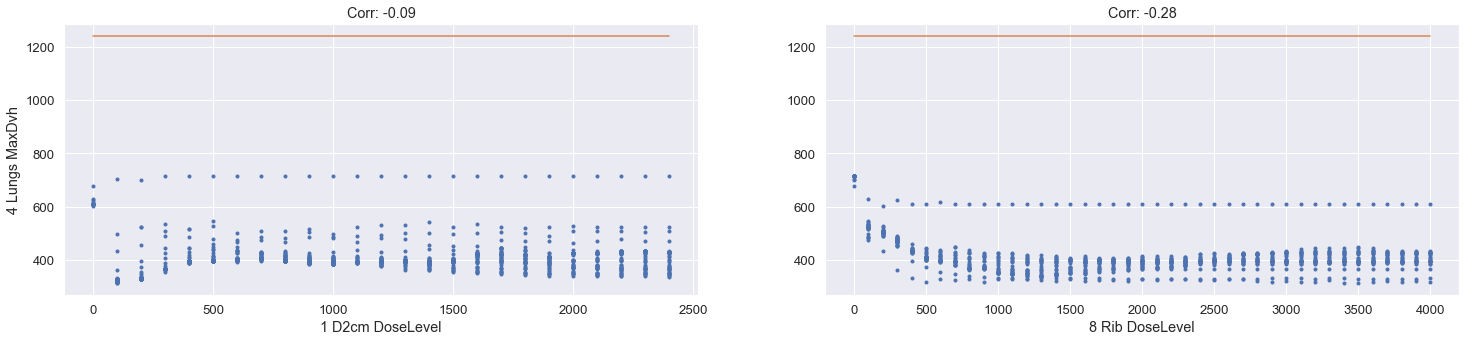

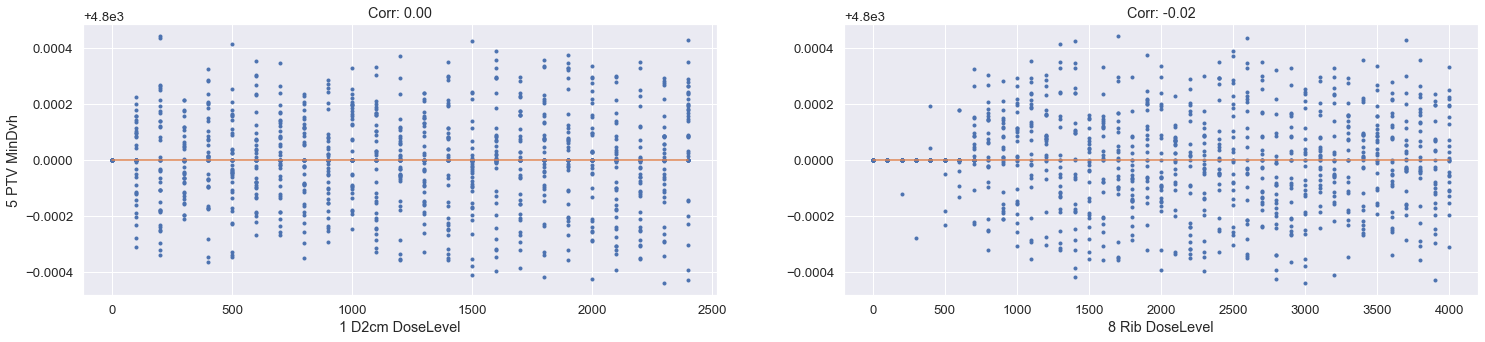

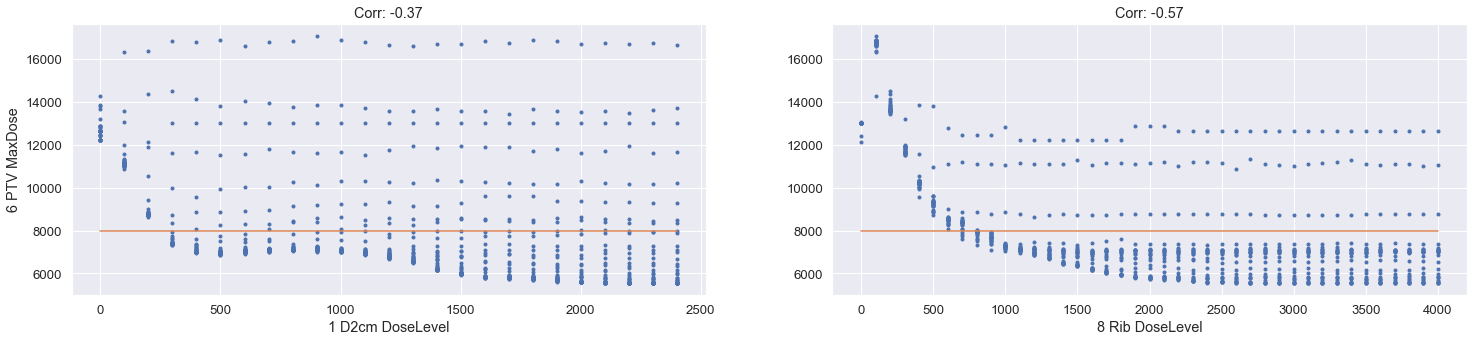

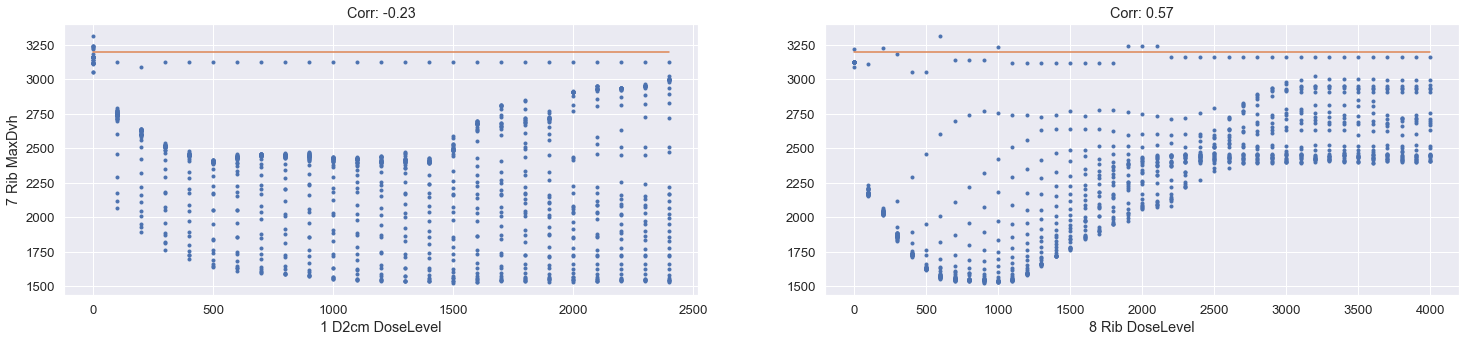

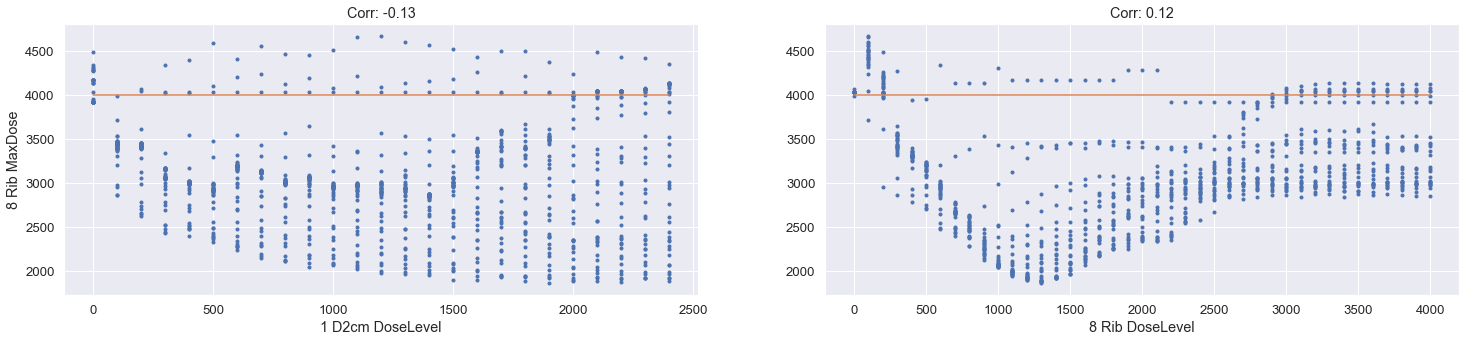

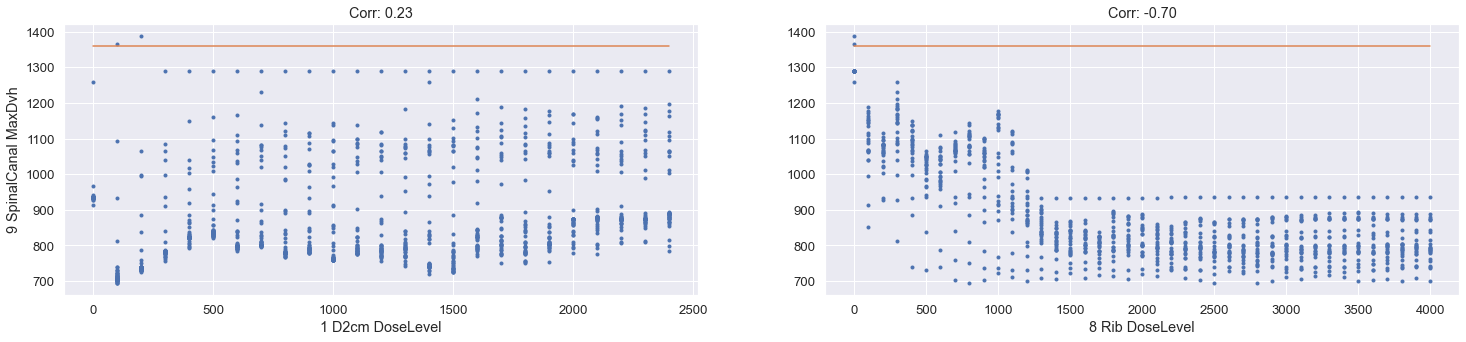

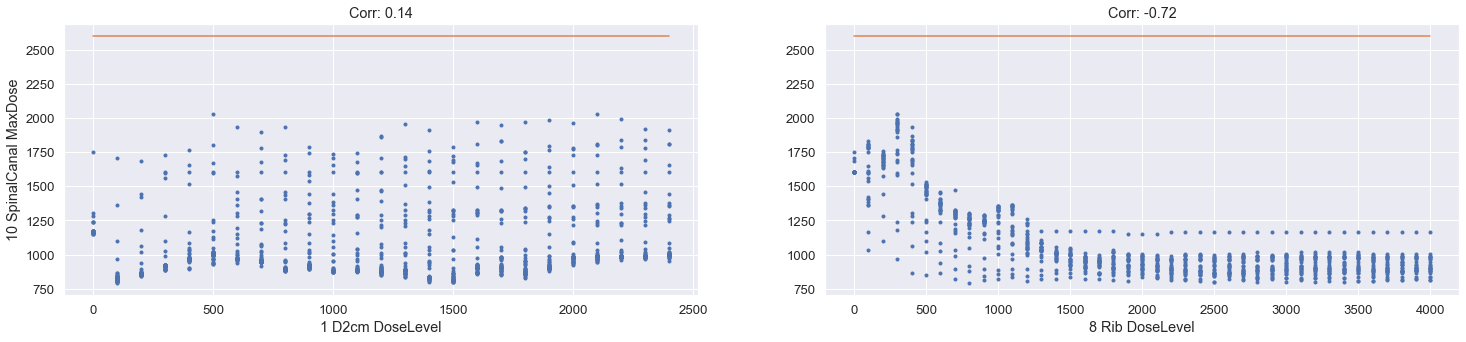

In [223]:
# Goal values vs. par values
default.func_df = raybay.get_funcs('grid2/funcs.csv')
analyze.scatterplot(default.goal_df, goal_dict, default.func_df, x_iters) # would be nice to color by par values

# Linear Utility

Grid Max Utility 461, Rib: 14, D2cm: 17


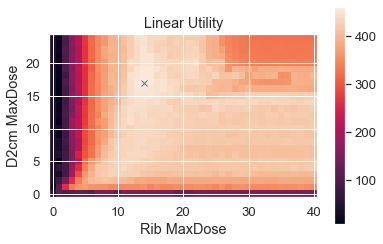

In [38]:
# Linear utility vs. parameters
Z_lin = np.zeros_like(X)
k = 0
for ii in range(len(d2cm_grid)):
    for jj in range(len(rib_grid)):
        for index, row in default.goal_df.iterrows():
            Z_lin[jj, ii] += raybay.get_term(goal_dict[index][k], row['AcceptanceLevel'], row['Type'], 'linear')
        k += 1
plt.imshow(Z_lin.T, origin='lower')
idx_lin = np.unravel_index(np.argmax(Z_lin), Z_lin.shape)
plt.plot(idx_lin[0], idx_lin[1], 'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear Utility')
plt.colorbar()

print(f'Grid Max Utility {np.max(Z_lin)}, Rib: {idx_lin[0]}, D2cm: {idx_lin[1]}')

Grid Max Utility 287, Rib: 17, D2cm: 16


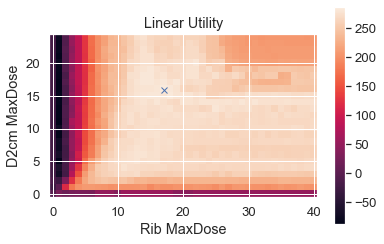

In [39]:
# Linear utility vs. parameters
Z_lin = np.zeros_like(X)
k = 0
for ii in range(len(d2cm_grid)):
    for jj in range(len(rib_grid)):
        for index, row in default.goal_df.iterrows():
            if 'Rib' in row['Roi'] or 'Lung' in row['Roi'] or 'Spinal' in row['Roi']:
                coeff = 0.5
            else:
                coeff = 1.0
            Z_lin[jj, ii] += coeff*raybay.get_term(goal_dict[index][k], row['AcceptanceLevel'], row['Type'], 'linear')
        k += 1
plt.imshow(Z_lin.T, origin='lower')
idx_lin = np.unravel_index(np.argmax(Z_lin), Z_lin.shape)
plt.plot(idx_lin[0], idx_lin[1], 'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear Utility')
plt.colorbar()

print(f'Grid Max Utility {np.max(Z_lin)}, Rib: {idx_lin[0]}, D2cm: {idx_lin[1]}')

## Dummy Minimize

In [17]:
res_dummy = np.load('bayes/res_linear_dummy_minimize.pkl', allow_pickle=True)
d2cm_dummy = [row[0]/100 for row in res_dummy.opt_result.x_iters]
rib_dummy = [row[1]/100 for row in res_dummy.opt_result.x_iters]

Grid Max Utility 461, Rib: 14, D2cm: 17
Dummy Max Utility 451.00, Rib: 15.10, D2cm: 21.41


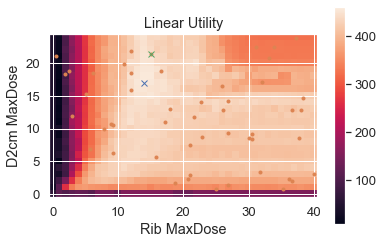

In [69]:
plt.imshow(Z_lin.T, origin='lower')
idx = np.unravel_index(np.argmax(Z_lin), Z_lin.shape)
plt.plot(idx[0], idx[1], 'x')
plt.plot(rib_dummy, d2cm_dummy, '.')
plt.plot(res_dummy.opt_result.x[1]/100, res_dummy.opt_result.x[0]/100,'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear Utility')
plt.colorbar()

print(f'Grid Max Utility {np.max(Z_lin)}, Rib: {idx_lin[0]}, D2cm: {idx_lin[1]}')
print(f'Dummy Max Utility {-res_dummy.opt_result.fun:.2f}, Rib: {res_dummy.opt_result.x[1]/100:.2f}, D2cm: {res_dummy.opt_result.x[0]/100:.2f}')

## GP Minimize

In [27]:
res_lin_gp = np.load('bayes/res_linear_gp_minimize.pkl', allow_pickle=True)
d2cm_lin_gp = [row[0]/100 for row in res_lin_gp.opt_result.x_iters]
rib_lin_gp = [row[1]/100 for row in res_lin_gp.opt_result.x_iters]

Grid Max Utility 461, Rib: 14, D2cm: 17
GP Max Utility 465.94, Rib: 15.25, D2cm: 18.42


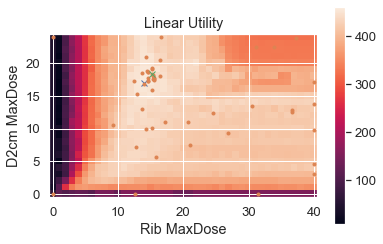

In [78]:
plt.imshow(Z_lin.T, origin='lower')
idx = np.unravel_index(np.argmax(Z_lin), Z_lin.shape)
plt.plot(idx[0], idx[1], 'x')
plt.plot(rib_lin_gp, d2cm_lin_gp, '.')
plt.plot(res_lin_gp.opt_result.x[1]/100, res_lin_gp.opt_result.x[0]/100,'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear Utility')
plt.colorbar()

print(f'Grid Max Utility {np.max(Z_lin)}, Rib: {idx_lin[0]}, D2cm: {idx_lin[1]}')
print(f'GP Max Utility {-res_lin_gp.opt_result.fun:.2f}, Rib: {res_lin_gp.opt_result.x[1]/100:.2f}, D2cm: {res_lin_gp.opt_result.x[0]/100:.2f}')

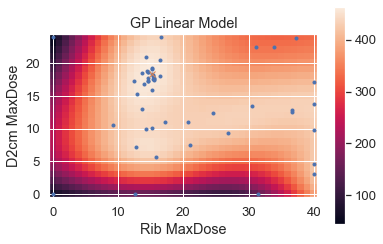

In [76]:
Z_lin_gp = np.zeros_like(X)
k = 0
for ii in range(len(d2cm_grid)):
    for jj in range(len(rib_grid)):
        Z_lin_gp[jj, ii] = -res_lin_gp.opt_result.models[-1].predict(np.array([d2cm_grid[ii]/2400,rib_grid[jj]/4000]).reshape(1, -1))[0]
plt.imshow(Z_lin_gp.T, origin='lower')
plt.plot(rib_lin_gp, d2cm_lin_gp, '.')
plt.plot(res_lin_gp.opt_result.x[1]/100, res_lin_gp.opt_result.x[0]/100,'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('GP Linear Model')
plt.colorbar();

## Convergence

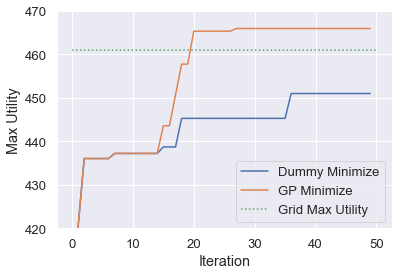

In [132]:
plt.plot(-np.minimum.accumulate(res_dummy.opt_result.func_vals))
plt.plot(-np.minimum.accumulate(res_lin_gp.opt_result.func_vals))
plt.plot([0, 50], [np.max(Z_lin), np.max(Z_lin)], ':')
plt.ylim([420, 470])
plt.xlabel('Iteration')
plt.ylabel('Max Utility')
plt.legend(['Dummy Minimize', 'GP Minimize', 'Grid Max Utility'])

# Linear-Quadratic Utility

In [35]:
# This one actually has two local maxima
np.where(Z_lq==np.max(Z_lq))

(array([13, 18]), array([ 5, 13]))

Grid Max Utility 439, Rib: (13, 18), D2cm: (5, 13)


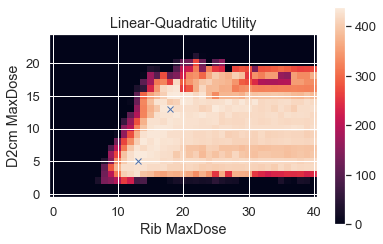

In [37]:
# Linear-quadratic utility vs. parameters
Z_lq = np.zeros_like(X)
k = 0
for ii in range(len(d2cm_grid)):
    for jj in range(len(rib_grid)):
        for index, row in default.goal_df.iterrows():
            Z_lq[jj, ii] += raybay.get_term(goal_dict[index][k], row['AcceptanceLevel'], row['Type'], 'linear_quadratic')
        k += 1
plt.imshow(Z_lq.T, origin='lower')
idx_lq = np.unravel_index(np.argmax(Z_lq), Z_lq.shape)
plt.plot([18, 13], [13, 5], 'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear-Quadratic Utility')
plt.colorbar()
plt.clim([0, 439])

print(f'Grid Max Utility {np.max(Z_lq)}, Rib: {13, 18}, D2cm: {5, 13}')

## Dummy Minimize

In [28]:
lq_dummy = np.zeros_like(rib_dummy)
for ii in range(len(rib_dummy)):
    for index, row in default.goal_df.iterrows():
        lq_dummy[ii] += raybay.get_term(res_dummy.goal_dict[index][ii], row['AcceptanceLevel'], row['Type'], 'linear_quadratic')
idx_dummy = np.argmax(lq_dummy)

Grid Max Utility 439, Rib: (13, 18), D2cm: (5, 13)
Dummy Max Utility 442.32, Rib: 22.64, D2cm: 14.03


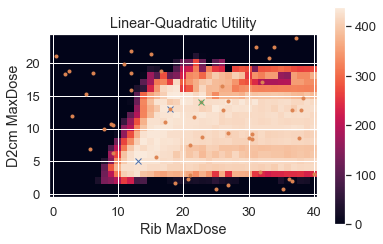

In [162]:
plt.imshow(Z_lq.T, origin='lower')
idx = np.unravel_index(np.argmax(Z_lin), Z_lin.shape)
plt.plot([18, 13], [13, 5], 'x')
plt.plot(rib_dummy, d2cm_dummy, '.')
plt.plot(rib_dummy[idx_dummy], d2cm_dummy[idx_dummy],'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear-Quadratic Utility')
plt.colorbar()
plt.clim(0, 439)

print(f'Grid Max Utility {np.max(Z_lq)}, Rib: {13, 18}, D2cm: {5, 13}')
print(f'Dummy Max Utility {lq_dummy[idx_dummy]:.2f}, Rib: {rib_dummy[idx_dummy]:.2f}, D2cm: {d2cm_dummy[idx_dummy]:.2f}')

## GP Minimize

In [29]:
res_lq_gp = np.load('bayes/res_linear_quadratic_gp_minimize.pkl', allow_pickle=True)
d2cm_lq_gp = [row[0]/100 for row in res_lq_gp.opt_result.x_iters]
rib_lq_gp = [row[1]/100 for row in res_lq_gp.opt_result.x_iters]

Grid Max Utility 439, Rib: (13, 18), D2cm: (5, 13)
GP Max Utility 445.79, Rib: 13.11, D2cm: 5.15


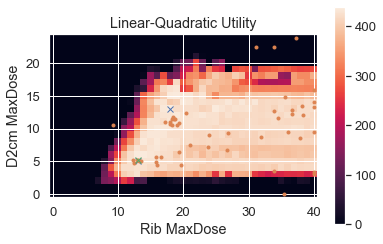

In [163]:
plt.imshow(Z_lq.T, origin='lower')
idx = np.unravel_index(np.argmax(Z_lq), Z_lq.shape)
plt.plot([18, 13], [13, 5], 'x')
plt.plot(rib_lq_gp, d2cm_lq_gp, '.')
plt.plot(res_lq_gp.opt_result.x[1]/100, res_lq_gp.opt_result.x[0]/100,'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear-Quadratic Utility')
plt.colorbar()
plt.clim([0, 439])

print(f'Grid Max Utility {np.max(Z_lq)}, Rib: {13, 18}, D2cm: {5, 13}')
print(f'GP Max Utility {-res_lq_gp.opt_result.fun:.2f}, Rib: {res_lq_gp.opt_result.x[1]/100:.2f}, D2cm: {res_lq_gp.opt_result.x[0]/100:.2f}')

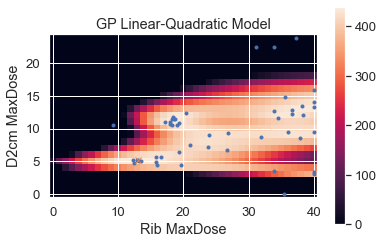

In [95]:
Z_lq_gp = np.zeros_like(X)
k = 0
for ii in range(len(d2cm_grid)):
    for jj in range(len(rib_grid)):
        Z_lq_gp[jj, ii] = -res_lq_gp.opt_result.models[-1].predict(np.array([d2cm_grid[ii]/2400,rib_grid[jj]/4000]).reshape(1, -1))[0]
plt.imshow(Z_lq_gp.T, origin='lower')
plt.plot(rib_lq_gp, d2cm_lq_gp, '.')
plt.plot(res_lq_gp.opt_result.x[1]/100, res_lq_gp.opt_result.x[0]/100,'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('GP Linear-Quadratic Model')
plt.colorbar()
plt.clim(0,439);

## Convergence

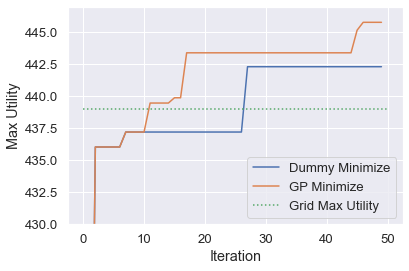

In [133]:
plt.plot(np.maximum.accumulate(lq_dummy))
plt.plot(-np.minimum.accumulate(res_lq_gp.opt_result.func_vals))
plt.plot([0, 50], [np.max(Z_lq), np.max(Z_lq)], ':')
plt.ylim([430, 447])
plt.xlabel('Iteration')
plt.ylabel('Max Utility')
plt.legend(['Dummy Minimize', 'GP Minimize', 'Grid Max Utility'])

# Linear-Quadratic Utility with Linear Rib Terms

In [164]:
# This one actually has two local maxima
np.where(Z_lqr==np.max(Z_lqr))

(array([13, 18]), array([ 5, 13]))

Grid Max Utility 439, Rib: (13, 18), D2cm: (5, 13)
Grid Max Utility 439, Rib: 13, D2cm: 5


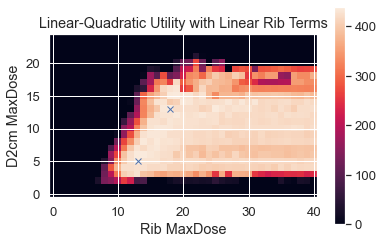

In [165]:
# Linear-quadratic utility vs. parameters (grid search same in most places, because rib meets goals in most places)
Z_lqr = np.zeros_like(X)
k = 0
for ii in range(len(d2cm_grid)):
    for jj in range(len(rib_grid)):
        for index, row in default.goal_df.iterrows():
            if 'Rib' in row['Roi']:
                Z_lqr[jj, ii] += raybay.get_term(goal_dict[index][k], row['AcceptanceLevel'], row['Type'], 'linear')
            else:
                Z_lqr[jj, ii] += raybay.get_term(goal_dict[index][k], row['AcceptanceLevel'], row['Type'], 'linear_quadratic')
        k += 1
plt.imshow(Z_lqr.T, origin='lower')
idx_lqr = np.unravel_index(np.argmax(Z_lqr), Z_lqr.shape)
plt.plot([18, 13], [13, 5], 'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear-Quadratic Utility with Linear Rib Terms')
plt.colorbar()
plt.clim([0, 439])

print(f'Grid Max Utility {np.max(Z_lqr)}, Rib: {13, 18}, D2cm: {5, 13}')

## Dummy Minimize

In [30]:
lqr_dummy = np.zeros_like(rib_dummy)
for ii in range(len(rib_dummy)):
    for index, row in default.goal_df.iterrows():
        if 'Rib' in row['Roi']:
            lqr_dummy[ii] += raybay.get_term(res_dummy.goal_dict[index][ii], row['AcceptanceLevel'], row['Type'], 'linear_quadratic')
        else:
            lqr_dummy[ii] += raybay.get_term(res_dummy.goal_dict[index][ii], row['AcceptanceLevel'], row['Type'], 'linear_quadratic')
idx_dummy = np.argmax(lqr_dummy)

Grid Max Utility 439, Rib: (13, 18), D2cm: (5, 13)
Dummy Max Utility 442.32, Rib: 22.64, D2cm: 14.03


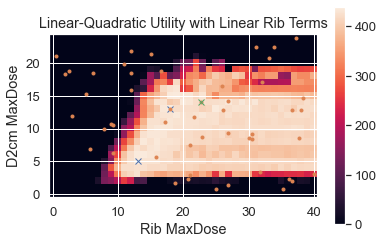

In [167]:
# Same result as linear-quadratic
plt.imshow(Z_lqr.T, origin='lower')
plt.plot([18, 13], [13, 5], 'x')
plt.plot(rib_dummy, d2cm_dummy, '.')
plt.plot(rib_dummy[idx_dummy], d2cm_dummy[idx_dummy],'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear-Quadratic Utility with Linear Rib Terms')
plt.colorbar()
plt.clim(0, 439)

print(f'Grid Max Utility {np.max(Z_lqr)}, Rib: {13, 18}, D2cm: {5, 13}')
print(f'Dummy Max Utility {lq_dummy[idx_dummy]:.2f}, Rib: {rib_dummy[idx_dummy]:.2f}, D2cm: {d2cm_dummy[idx_dummy]:.2f}')

## GP Minimize

In [31]:
res_lqr_gp = np.load('bayes/res_lin_rib_gp_minimize.pkl', allow_pickle=True)
d2cm_lqr_gp = [row[0]/100 for row in res_lqr_gp.opt_result.x_iters]
rib_lqr_gp = [row[1]/100 for row in res_lqr_gp.opt_result.x_iters]

Grid Max Utility 439, Rib: (13, 18), D2cm: (5, 13)
GP Max Utility 442.98, Rib: 25.68, D2cm: 13.30


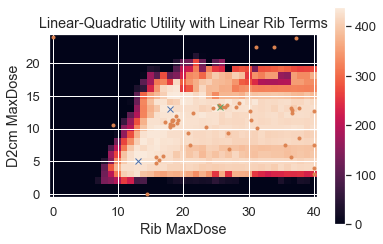

In [168]:
# Different result from linear-quadratic
plt.imshow(Z_lqr.T, origin='lower')
plt.plot([18, 13], [13, 5], 'x')
plt.plot(rib_lqr_gp, d2cm_lqr_gp, '.')
plt.plot(res_lqr_gp.opt_result.x[1]/100, res_lqr_gp.opt_result.x[0]/100,'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear-Quadratic Utility with Linear Rib Terms')
plt.colorbar()
plt.clim([0, 439])

print(f'Grid Max Utility {np.max(Z_lqr)}, Rib: {13, 18}, D2cm: {5, 13}')
print(f'GP Max Utility {-res_lqr_gp.opt_result.fun:.2f}, Rib: {res_lqr_gp.opt_result.x[1]/100:.2f}, D2cm: {res_lqr_gp.opt_result.x[0]/100:.2f}')

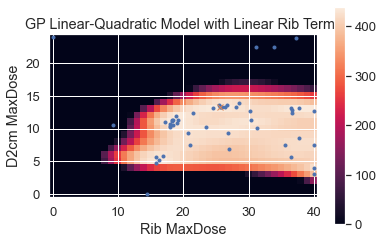

In [148]:
# Different result from linear-quadratic
Z_lqr_gp = np.zeros_like(X)
k = 0
for ii in range(len(d2cm_grid)):
    for jj in range(len(rib_grid)):
        Z_lqr_gp[jj, ii] = -res_lqr_gp.opt_result.models[-1].predict(np.array([d2cm_grid[ii]/2400,rib_grid[jj]/4000]).reshape(1, -1))[0]
plt.imshow(Z_lqr_gp.T, origin='lower')
plt.plot(rib_lqr_gp, d2cm_lqr_gp, '.')
plt.plot(res_lqr_gp.opt_result.x[1]/100, res_lqr_gp.opt_result.x[0]/100,'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('GP Linear-Quadratic Model with Linear Rib Terms')
plt.colorbar()
plt.clim(0,439);

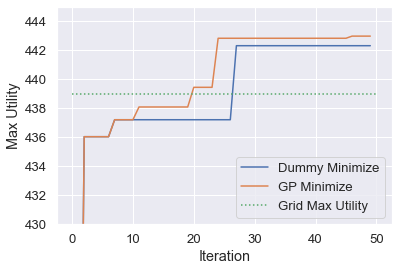

In [147]:
plt.plot(np.maximum.accumulate(lqr_dummy))
plt.plot(-np.minimum.accumulate(res_lqr_gp.opt_result.func_vals))
plt.plot([0, 50], [np.max(Z_lqr), np.max(Z_lqr)], ':')
plt.ylim([430, 445])
plt.xlabel('Iteration')
plt.ylabel('Max Utility')
plt.legend(['Dummy Minimize', 'GP Minimize', 'Grid Max Utility'], loc='lower right')

# Linear-Quadratic Utility with Linear Rib and Chestwall Terms

In [14]:
# This one actually has two local maxima (same as previous two examples)
np.where(Z_lqrc==np.max(Z_lqrc))

(array([13, 18]), array([ 5, 13]))

Grid Max Utility 439, Rib: (13, 18), D2cm: (5, 13)


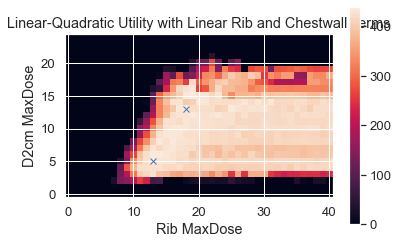

In [15]:
# Linear-quadratic utility vs. parameters
Z_lqrc = np.zeros_like(X)
k = 0
for ii in range(len(d2cm_grid)):
    for jj in range(len(rib_grid)):
        for index, row in default.goal_df.iterrows():
            if 'Rib' in row['Roi'] or 'Chest' in row['Roi']:
                Z_lqrc[jj, ii] += raybay.get_term(goal_dict[index][k], row['AcceptanceLevel'], row['Type'], 'linear')
            else:
                Z_lqrc[jj, ii] += raybay.get_term(goal_dict[index][k], row['AcceptanceLevel'], row['Type'], 'linear_quadratic')
        k += 1
plt.imshow(Z_lqrc.T, origin='lower')
idx_lqr = np.unravel_index(np.argmax(Z_lqrc), Z_lqrc.shape)
plt.plot([18, 13], [13, 5], 'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear-Quadratic Utility with Linear Rib and Chestwall Terms')
plt.colorbar()
plt.clim([0, 439])

print(f'Grid Max Utility {np.max(Z_lqrc)}, Rib: {13, 18}, D2cm: {5, 13}')

## Dummy Minimize

In [18]:
lqrc_dummy = np.zeros_like(rib_dummy)
for ii in range(len(rib_dummy)):
    for index, row in default.goal_df.iterrows():
        if 'Rib' in row['Roi'] or 'Chest' in row['Roi']:
            lqrc_dummy[ii] += raybay.get_term(res_dummy.goal_dict[index][ii], row['AcceptanceLevel'], row['Type'], 'linear_quadratic')
        else:
            lqrc_dummy[ii] += raybay.get_term(res_dummy.goal_dict[index][ii], row['AcceptanceLevel'], row['Type'], 'linear_quadratic')
idx_dummy = np.argmax(lqrc_dummy)

Grid Max Utility 439, Rib: (13, 18), D2cm: (5, 13)
Dummy Max Utility 442.32, Rib: 22.64, D2cm: 14.03


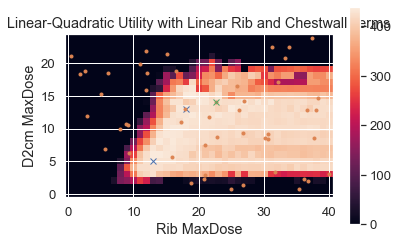

In [20]:
# Same result as linear-quadratic
plt.imshow(Z_lqrc.T, origin='lower')
plt.plot([18, 13], [13, 5], 'x')
plt.plot(rib_dummy, d2cm_dummy, '.')
plt.plot(rib_dummy[idx_dummy], d2cm_dummy[idx_dummy],'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear-Quadratic Utility with Linear Rib and Chestwall Terms')
plt.colorbar()
plt.clim(0, 439)

print(f'Grid Max Utility {np.max(Z_lqrc)}, Rib: {13, 18}, D2cm: {5, 13}')
print(f'Dummy Max Utility {lqrc_dummy[idx_dummy]:.2f}, Rib: {rib_dummy[idx_dummy]:.2f}, D2cm: {d2cm_dummy[idx_dummy]:.2f}')

In [ ]:
# Try with chestwall linear terms...

# Compare Goal Values

## Patient 1

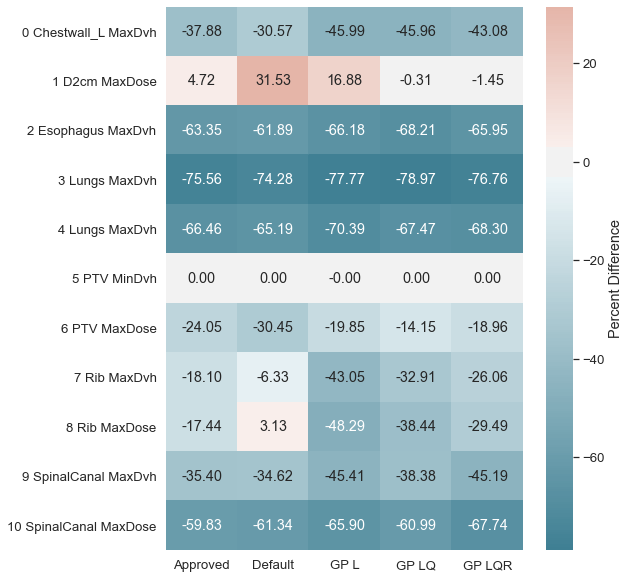

In [32]:
roi_dict = {
    f"{index} {row['Roi']} {row['Type']}": index for index, row in approved.goal_df.iterrows()
}
X = np.zeros((len(approved.goal_df), 5))
for index, row in approved.goal_df.iterrows():
    X[index, 0] = -raybay.get_term(approved.goal_dict[index][0], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 1] = -raybay.get_term(default.goal_dict[index][0], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 2] = -raybay.get_term(res_lin_gp.goal_dict[index][np.argmin(res_lin_gp.opt_result.func_vals)], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 3] = -raybay.get_term(res_lq_gp.goal_dict[index][np.argmin(res_lq_gp.opt_result.func_vals)], row['AcceptanceLevel'], 'Max', 'linear') 
    X[index, 4] = -raybay.get_term(res_lqr_gp.goal_dict[index][np.argmin(res_lqr_gp.opt_result.func_vals)], row['AcceptanceLevel'], 'Max', 'linear')
Y = pd.DataFrame(columns=['Approved', 'Default', 'GP L', 'GP LQ', 'GP LQR'], data=X, index=roi_dict)
f, ax = plt.subplots(1, figsize=(8, 10))
sns.heatmap(Y, annot=True, cmap=sns.diverging_palette(220, 20, n=256), ax=ax, cbar_kws={'label': 'Percent Difference'},
            fmt='.2f', center=0);

In [ ]:
# try with new function (linear rib and chestwall) with and without averaging for lungs, ribs, and spinal canal!